### Importing all the important Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import os
import time

from IPython.display import clear_output
import cv2

Setting memory growth of gpu. This avoids any error based on resources. (ResourceExhaustionError)

In [2]:
#Code to a void the cuda gpu error
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Extraction of images from the videos. 

The code below will only extract the faces from the videos. There are a few chances of error where the code will mistake something else to be the face. Look through the image folder manually.

I have set the images to be of the size of 64x64 pixels.

In [4]:

# get the video and get all the images in it.
# path of data:
import cv2
from PIL import Image
import numpy as np
path = 'C:/Users/astro/Documents/Python Projects/Auto encoders/Project-2 (face swap, Manu and me)/data'
a_path = path + '/jigar_video3.mp4'
b_path = path + '/dad_video1.mp4'

image_folder = path + '/images'
b_images = image_folder+'/dad_images/'
a_images = image_folder+'/jigar_images/'

def get_images(path_to_video, save_imgs_to, num_images = 9000):
    vid = cv2.VideoCapture(path_to_video)
    i=0
    vid = cv2.VideoCapture(path_to_video)
    print('Processing...')
    while i<num_images:

        # Capture the video frame
        # by frame
        ret, frame = vid.read()


        

        frame = np.array(frame)
        
        # Convert into grayscale (for finding face)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), 
                          (0, 0, 255), 2)

            faces = frame[y:y + h, x:x + w]
        try:
            cv2.imshow('img', faces)

            # Convert from BGR to RGB color format
            image = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)

            #Resizing image
            # Converting images to 128*128 format        
            # Saving every frame
            image=Image.fromarray(image)
            image = image.resize((64,64),Image.ANTIALIAS)

            image.save(save_imgs_to + str(i) + '.jpg')

            i+=1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        except:
            print('No face detected')
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

# get_images(path_to_video = b_path, save_imgs_to=b_images)
#get_images(path_to_video = a_path, save_imgs_to=a_images)
print('Done')

Done


In [5]:
path = 'C:/Users/astro/Documents/Python Projects/Auto encoders/Project-2 (face swap, Manu and me)/data'

image_folder = path + '/images'
a_folder = image_folder+'/jigar_images/'
b_folder = image_folder+'/dad_images/'

The below code converts the images into NumPy arrays.

In [6]:
image_shape = [64, 64,3]

# A person set up
a_images = []
image_folder_path = a_folder
for image_name in os.listdir(image_folder_path):
    full_image_name = os.path.join(image_folder_path,image_name)
    #converting image to array
    img_arr = plt.imread(full_image_name)
    a_images.append(img_arr/255) #also normalizing between 0 to 1.
a_images = np.array(a_images,dtype='float32')[:4084]
print(a_images.shape)

# B person set up
b_images = []
image_folder_path = b_folder
for image_name in os.listdir(image_folder_path):
    full_image_name = os.path.join(image_folder_path,image_name)
    #converting image to array
    img_arr = plt.imread(full_image_name)
    b_images.append(img_arr/255) #also normalizing between 0 to 1.
b_images = np.array(b_images, dtype='float32')[:4084]
print(b_images.shape)

(4084, 64, 64, 3)
(4084, 64, 64, 3)


Plotting samples just to be safe.

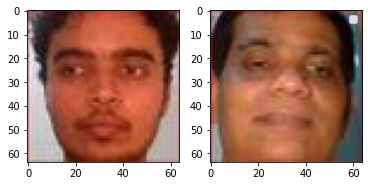

In [7]:
# plotting for the feels:
fig, axes = plt.subplots(1,2)

axes[0].imshow(a_images[0], label='me')
axes[1].imshow(b_images[0], label = 'manu')
plt.legend(['Me', 'Dad'])
plt.show()

## The layers for encoder:

In [10]:
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((3,3,1024)))(x)
encoded = layers.Reshape((3,3,1024))(x)
encoder = tf.keras.Model(input_img, encoded,name="encoder")

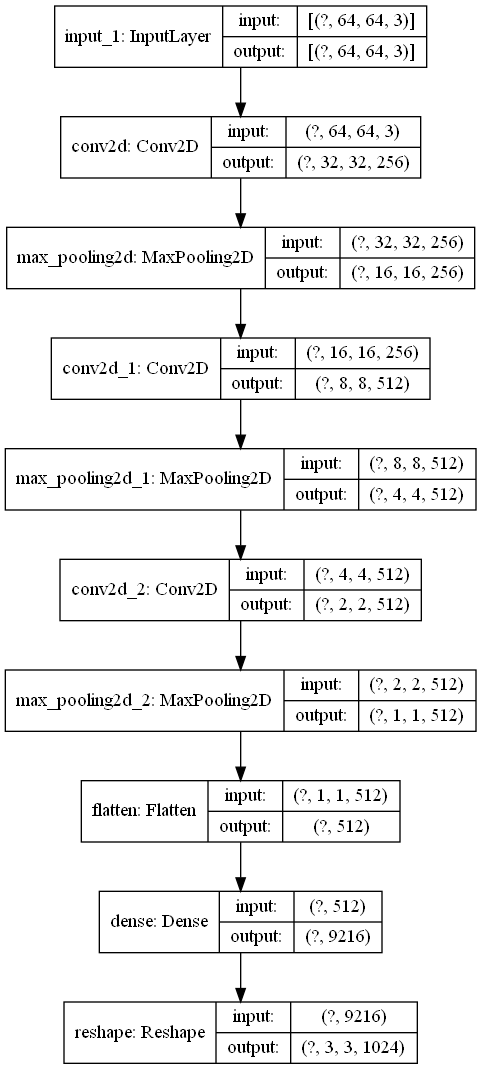

In [11]:
tf.keras.utils.plot_model(encoder, to_file='encoder.png', show_shapes=True)

## The layers for decoder:

In [12]:
decoder_input= layers.Input(shape=((3,3,1024)))
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(decoder_input)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256,kernel_size=5, strides=2, padding='same',activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(np.prod((64, 64, 3)))(x)
decoded = layers.Reshape((64, 64, 3))(x)
decoder = tf.keras.Model(decoder_input, decoded,name="decoder")

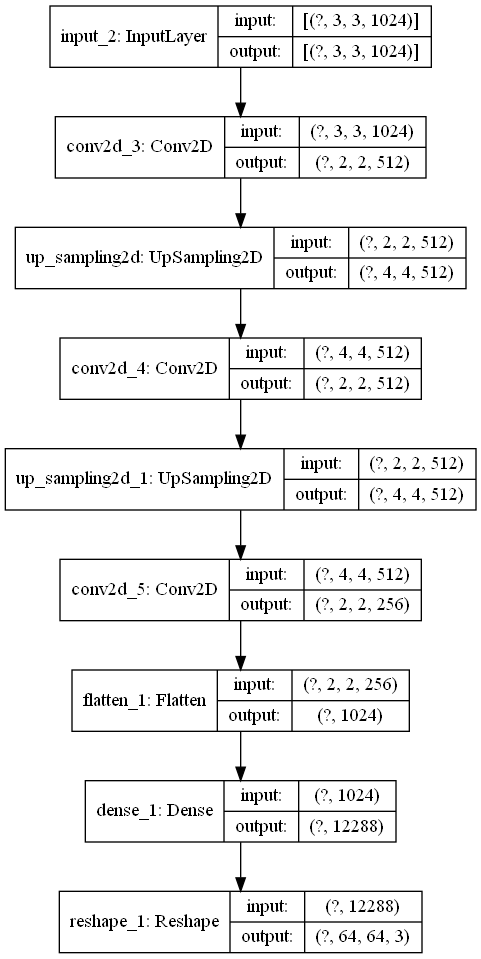

In [13]:
tf.keras.utils.plot_model(decoder, to_file='decoder.png', show_shapes=True)

## Making the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 3, 3, 1024)        14578688  
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 3)         35534080  
Total params: 50,112,768
Trainable params: 50,112,768
Non-trainable params: 0
_________________________________________________________________


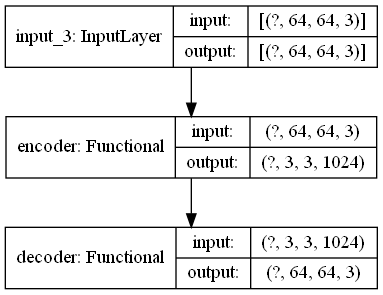

In [14]:
auto_input = layers.Input(shape=(64,64,3))
encoded = encoder(auto_input)
decoded = decoder(encoded)
 
autoencoder = tf.keras.Model(auto_input, decoded,name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-5, beta_1=0.5, beta_2=0.999), loss='mae')
autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [15]:
autoencoder.layers[0].input

<tf.Tensor 'input_3:0' shape=(None, 64, 64, 3) dtype=float32>

In [16]:
EPOCHS=5000

# Function to generate image from autoencoder:

In [15]:
def generate_img(autoencoder, input_image):
    # takes a (256,256,3) image
    # outputs a (256,256,3) image
    input_image = input_image.reshape((1,)+input_image.shape)
    output_image = autoencoder(input_image)
    display_list = [input_image[0], output_image[0]]
    title = ['input','auto_encoded']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

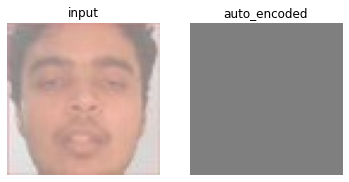

In [16]:
generate_img(autoencoder=autoencoder,input_image=a_images[78])

## train, test split:

In [17]:
a_train, a_test = a_images[:4000],a_images[4000:]
b_train, b_test = b_images[:4000], b_images[4000:]

Training the model. I have already trained it. Hence the comment

In [11]:
# checkpoint1 = callbacks.ModelCheckpoint('autoencoder1.h5', monitor='val_loss',
#                                         verbose = 1, save_best_only=True,
#                                        mode='auto', period=1)
# history1 = autoencoder.fit(a_train,a_train, epochs=EPOCHS, batch_size=256,
#                             shuffle=True, validation_data=(a_test,a_test),
#                             callbacks=[checkpoint1])


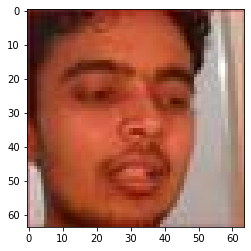

In [22]:
plt.imshow(a_test[60])

In [19]:
np.array(a_test[2]).shape

(64, 64, 3)

Loading the model:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


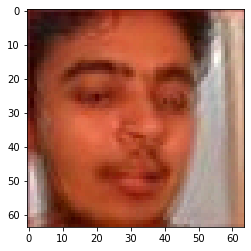

In [23]:
with tf.device('/CPU:0'):
    autoencoder_a = tf.keras.models.load_model('autoencoder1.h5')
op_img = autoencoder_a.predict(np.array([a_test[60]]))
plt.imshow(op_img[0])

In [16]:
# checkpoint2 = callbacks.ModelCheckpoint('autoencoder2.h5', monitor='val_loss',
#                                         verbose = 1, save_best_only=True,
#                                        mode='auto', period=1)
# history2 = autoencoder.fit(b_train,b_train, epochs=EPOCHS, batch_size=256,
#                             shuffle=True, validation_data=(b_test,b_test),
#                             callbacks=[checkpoint2])


In [17]:
# autoencoder.save('autoencoder_backup_after_2.h5')

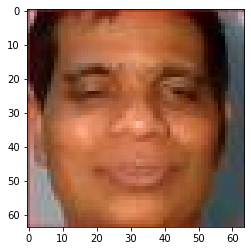

In [26]:
plt.imshow(b_test[5])

In [30]:
with tf.device('/CPU:0'):
    autoencoder_b = tf.keras.models.load_model('autoencoder2.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


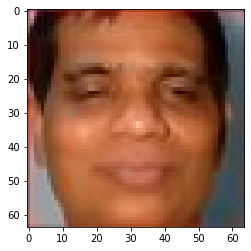

In [51]:
op_img = autoencoder_b.predict(np.array([b_test[5]]))
plt.imshow(op_img[0])

In [32]:
autoencoder_a.layers

Dividing the autoencoders into 4 parts:

In [33]:
# TO LOAD ONLY THE ENCODER A
encoder_a = tf.keras.Model(autoencoder_a.layers[1].input, autoencoder_a.layers[1].output)
# TO LOAD ONLY THE DECODER A
decoder_a = tf.keras.Model(autoencoder_a.layers[2].input, autoencoder_a.layers[2].output)
# TO LOAD ONLY THE ENCODER B
encoder_b = tf.keras.Model(autoencoder_b.layers[1].input, autoencoder_b.layers[1].output)
# TO LOAD ONLY THE DECODER B
decoder_b = tf.keras.Model(autoencoder_b.layers[2].input, autoencoder_b.layers[2].output)

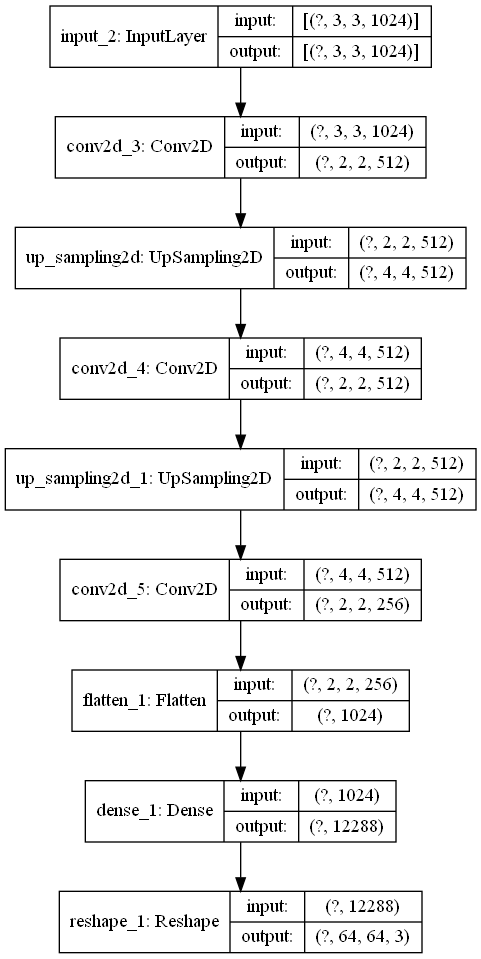

In [34]:
tf.keras.utils.plot_model(decoder_a,show_shapes=True)

In [46]:
input_test = encoder_a.predict(np.array([a_test[30]]))
output_test = decoder_b.predict(input_test)

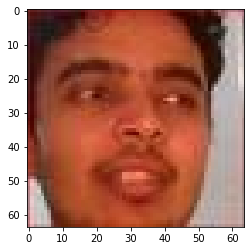

In [42]:
plt.imshow(a_test[30])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


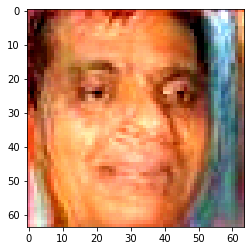

In [47]:
plt.imshow(output_test[0])

I think it needs some more data and more number of epochs. I have trained the two autoencoders for 5000 epochs. It took me around 30 hours. 

# Below code description:
The code opens up two opencv windows. One is the camera window and the other is the autoencoded window. My face is extracted from the input and then converted to my father's face.

In [50]:
import cv2
from PIL import Image
vid = cv2.VideoCapture(0) 

i=0
while i<1000: 
      
    # Capture the video frame 
    # by frame 
    ret, frame = vid.read() 
    #print(type(frame))
    # Converting images to 128*128 format
    image = Image.fromarray(frame)
    frame = np.array(image)
    # Convert into grayscale (for finding face)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), 
                      (0, 0, 255), 2)

        faces = frame[y:y + h, x:x + w]

    
    frame = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame)
    frame = image.resize((64,64),Image.ANTIALIAS)

    frame = np.array(frame)
    cv2.imshow('img', frame)
    
    refurb_fram = frame.reshape(1,64,64,3)
    refurb_fram = (refurb_fram/255)  
    gen_op = (encoder_a(refurb_fram).numpy())
    # tell cv2 to display this image:
    display_img = cv2.cvtColor(decoder_b.predict(gen_op)[0],cv2.COLOR_RGB2BGR)
    cv2.imshow('generated Output', display_img)
    
    i+=1
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
# Afterthe loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 